[View in Colaboratory](https://colab.research.google.com/github/margaretmz/fastai-notebooks/blob/master/lesson5_movielens_colab_version.ipynb)

## Fast.ai Lesson 5 Movielens
**Updated to run in Google colab by Margaret Maynard-Reid, 8/23/2018**

This notebook demonstrates collabrative filtering with PyTorch code. 

### Additional code for colab version [Margaret]

In [1]:
# Install fast.ai library
!pip install fastai

    100% |████████████████████████████████| 122kB 3.6MB/s 
    100% |████████████████████████████████| 2.2MB 6.8MB/s 
    100% |████████████████████████████████| 61kB 13.7MB/s 
    100% |████████████████████████████████| 184kB 10.8MB/s 
    100% |████████████████████████████████| 112kB 14.5MB/s 
    100% |████████████████████████████████| 1.5MB 9.9MB/s 
    100% |████████████████████████████████| 496.4MB 35kB/s 
    100% |████████████████████████████████| 51kB 20.7MB/s 
    100% |████████████████████████████████| 3.6MB 4.4MB/s 
    100% |████████████████████████████████| 11.6MB 2.6MB/s 
    100% |████████████████████████████████| 92kB 26.8MB/s 
    100% |████████████████████████████████| 112kB 29.1MB/s 
    100% |████████████████████████████████| 71kB 17.4MB/s 
    100% |████████████████████████████████| 901kB 2.9MB/s 
    100% |████████████████████████████████| 81kB 26.7MB/s 
    100% |████████████████████████████████| 15.8MB 2.4MB/s 
    100% |████████████████████████████████| 4.4MB 

In [10]:
# Get the data, unzip it, and put it in the 'data' directory:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip && unzip ml-latest-small.zip -d data/


Redirecting output to ‘wget-log.2’.
Archive:  ml-latest-small.zip
   creating: data/ml-latest-small/
  inflating: data/ml-latest-small/links.csv  
  inflating: data/ml-latest-small/movies.csv  
  inflating: data/ml-latest-small/ratings.csv  
  inflating: data/ml-latest-small/README.txt  
  inflating: data/ml-latest-small/tags.csv  


In [16]:
# Check to make sure the folders all unzipped properly:
!ls data/ml-latest-small

links.csv  movies.csv  ratings.csv  README.txt	tags.csv


### Inspect the data

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [0]:
path='data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [19]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [22]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [23]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

In [0]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50

In [0]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [27]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   
    0      0.796206   0.805105  
    1      0.744912   0.779749  
    2      0.614075   0.765927  



[array([0.76593])]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [28]:
math.sqrt(0.776)

0.8809086218218096

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [0]:
preds = learn.predict()

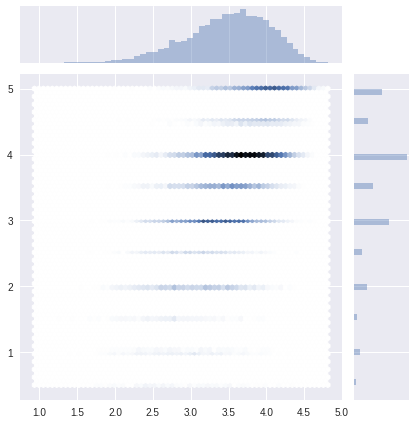

In [30]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [0]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [32]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [0]:
# Convert movie bias to numpy arrays
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [34]:
movie_bias

array([[ 0.8165 ],
       [ 0.85096],
       [ 1.27259],
       ...,
       [ 0.26091],
       [-0.09211],
       [ 0.25567]], dtype=float32)

In [0]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [36]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.8902679, 'Battlefield Earth (2000)'),
 (-0.8041978, 'Anaconda (1997)'),
 (-0.7916279, 'Wild Wild West (1999)'),
 (-0.76377445, 'Speed 2: Cruise Control (1997)'),
 (-0.70415944, 'Super Mario Bros. (1993)'),
 (-0.6979411, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.6976562, 'Inspector Gadget (1999)'),
 (-0.67505306, 'Congo (1995)'),
 (-0.6729513, 'Batman & Robin (1997)'),
 (-0.6342164, 'Bio-Dome (1996)'),
 (-0.62521166, 'Howard the Duck (1986)'),
 (-0.6103515, 'Flintstones, The (1994)'),
 (-0.6060233, 'Jaws 3-D (1983)'),
 (-0.5974889, 'Haunting, The (1999)'),
 (-0.59135395, 'Superman III (1983)')]

In [37]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.8902679, 'Battlefield Earth (2000)'),
 (-0.8041978, 'Anaconda (1997)'),
 (-0.7916279, 'Wild Wild West (1999)'),
 (-0.76377445, 'Speed 2: Cruise Control (1997)'),
 (-0.70415944, 'Super Mario Bros. (1993)'),
 (-0.6979411, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.6976562, 'Inspector Gadget (1999)'),
 (-0.67505306, 'Congo (1995)'),
 (-0.6729513, 'Batman & Robin (1997)'),
 (-0.6342164, 'Bio-Dome (1996)'),
 (-0.62521166, 'Howard the Duck (1986)'),
 (-0.6103515, 'Flintstones, The (1994)'),
 (-0.6060233, 'Jaws 3-D (1983)'),
 (-0.5974889, 'Haunting, The (1999)'),
 (-0.59135395, 'Superman III (1983)')]

In [38]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.2725899, 'Shawshank Redemption, The (1994)'),
 (1.0168698, 'Godfather, The (1972)'),
 (1.010046, 'Godfather: Part II, The (1974)'),
 (0.99035233, 'Usual Suspects, The (1995)'),
 (0.9889479, "Schindler's List (1993)"),
 (0.9488542, 'Fargo (1996)'),
 (0.9327262, '12 Angry Men (1957)'),
 (0.8908902, 'Dark Knight, The (2008)'),
 (0.88883257, 'Silence of the Lambs, The (1991)'),
 (0.85311544, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (0.8509646, 'Pulp Fiction (1994)'),
 (0.8472333, 'Rear Window (1954)'),
 (0.84584624, 'Matrix, The (1999)'),
 (0.8309882, 'To Kill a Mockingbird (1962)'),
 (0.82577693, 'Star Wars: Episode IV - A New Hope (1977)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [39]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [41]:
movie_pca.shape

(3, 3000)

In [0]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [43]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.06578843, 'Armageddon (1998)'),
 (0.063973, 'Police Academy 4: Citizens on Patrol (1987)'),
 (0.06315456, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.06297481, 'Waterworld (1995)'),
 (0.0586639, 'Outbreak (1995)'),
 (0.05354081, "Charlie's Angels (2000)"),
 (0.05217462, 'Police Academy 3: Back in Training (1986)'),
 (0.05172131, 'Home Alone 3 (1997)'),
 (0.05052669, 'Jack Frost (1998)'),
 (0.050234023, 'Lake Placid (1999)')]

In [44]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.07894555, 'Pulp Fiction (1994)'),
 (-0.075212695, 'Godfather, The (1972)'),
 (-0.06796461, 'Chinatown (1974)'),
 (-0.06516264, 'Taxi Driver (1976)'),
 (-0.0640882, 'Apocalypse Now (1979)'),
 (-0.060455356,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (-0.060279638, 'Fargo (1996)'),
 (-0.057533108, 'Being John Malkovich (1999)'),
 (-0.05746345, 'Goodfellas (1990)'),
 (-0.05745116, 'Godfather: Part II, The (1974)')]

In [0]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [46]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.058836162, 'Tank Girl (1995)'),
 (0.05590784, 'Island of Dr. Moreau, The (1996)'),
 (0.052672286, 'Clockwork Orange, A (1971)'),
 (0.052114777, 'American Psycho (2000)'),
 (0.048785135, 'Thin Red Line, The (1998)'),
 (0.048771214, 'Home Alone 2: Lost in New York (1992)'),
 (0.047532715, '8 1/2 (8½) (1963)'),
 (0.046364162, 'Nightmare Before Christmas, The (1993)'),
 (0.046298943, 'Airheads (1994)'),
 (0.04520805, 'Catwoman (2004)')]

In [47]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.110408485, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.10547924, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.105033405, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.10456386, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.09945258, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.09782016, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.092739195, 'Spider-Man (2002)'),
 (-0.091628015,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.08666568, "Schindler's List (1993)"),
 (-0.08518734, 'Jurassic Park (1993)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

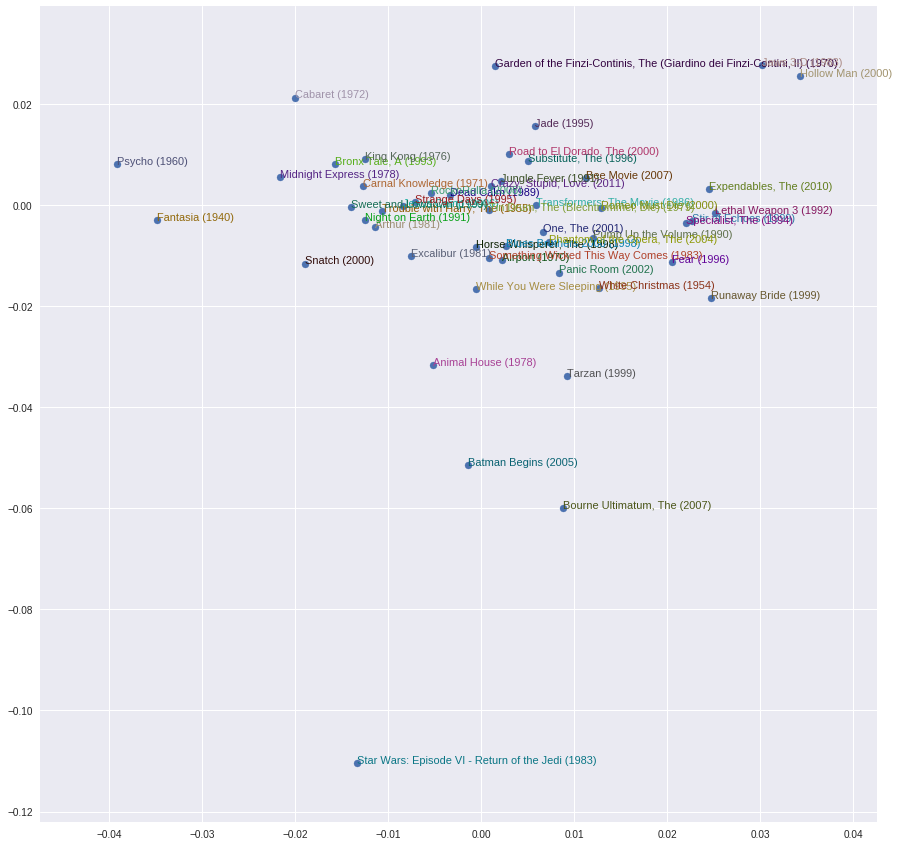

In [48]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [49]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)], 
   2   2
  10  10
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)])

In [50]:
a*b


  2   4
 30  40
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]

In [51]:
(a*b).sum(1)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

In [0]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [0]:
model=DotProduct()

In [54]:
model(a,b)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

### Dot product model

In [0]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [0]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)

In [0]:
# x has all columns except for 'rating' and 'timestamp'
x = ratings.drop(['rating', 'timestamp'],axis=1)
# y has only the 'rating' column
y = ratings['rating'].astype(np.float32)

In [0]:
# Create data with fast.ai library
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [0]:
wd=1e-5
# Create the model
model = EmbeddingDot(n_users, n_movies).cuda()
# Create an optimizer
opt = optim.SGD(model.parameters(), 
                1e-1, # learning rate
                weight_decay=wd, 
                momentum=0.9)

In [61]:
# fast.ai function fit() does the training loop
fit(model, # pytorch library model
    data, 
    3, 
    opt, 
    F.mse_loss)

epoch      trn_loss   val_loss   
    0      1.714039   1.638626  
    1      1.104591   1.295687  
    2      0.891994   1.22399   



[array([1.22399])]

In [0]:
# fast.ai function set_lrs() to set the learning rate manually
set_lrs(opt, # optimizer
        0.01) # learning rate

In [84]:
# Now the results (training and validation loss)look better
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      0.651251   1.126027  
    1      0.660319   1.122826  
    2      0.624794   1.120026  



[array([1.12003])]

### Bias

In [81]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [80]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, 
         self.m, 
         self.ub, # user bias
         self.mb) # movie bias
        = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze() # .squeeze is pytorch way of doing broadcasting
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res

SyntaxError: ignored

In [82]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda() # Put it on the GPU with .cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

TypeError: ignored

In [0]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.88212  0.83626]                                    
[ 1.       0.8108   0.81831]                                    
[ 2.       0.78864  0.80989]                                    



In [0]:
set_lrs(opt, 1e-2)

In [0]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.72795  0.80337]                                    
[ 1.       0.75064  0.80203]                                    
[ 2.       0.75122  0.80124]                                    



### Mini net

In [1]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
      # n_users - number of users
      # n_movies - number of movies
      # nh - number of hidden layers
      # p1 - dropout for the first layer
      # p2 - dropout for the 2nd layer
      
      
      
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 
                              1) # one prediction
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], # concatenate the user embedding with movies embedding
                                 dim=1)) # concate the columns
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

NameError: ignored

In [0]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [0]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.88043  0.82363]                                    
[ 1.       0.8941   0.81264]                                    
[ 2.       0.86179  0.80706]                                    



In [0]:
set_lrs(opt, 1e-3)

In [86]:
fit(model, data, 3, opt, F.mse_loss)

epoch      trn_loss   val_loss   
    0      0.604455   1.119272  
    1      0.589961   1.118724  
    2      0.621119   1.118368  



[array([1.11837])]